# Bitcoin

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.1f' % x)
df = pd.read_csv("./bitcoin.csv", index_col=0)
df.set_index(pd.to_datetime(df.index, unit='s'), inplace=True)
df.sort_index(inplace=True)

df2 = df['Price'].resample('8H').ohlc().fillna(method='ffill')
df2.head()

,open,high,low,close
Timestamp,,,,
2015-07-25 16:00:00,190001.0,190001.0,190001.0,190001.0
2015-07-26 00:00:00,190001.0,190001.0,190001.0,190001.0
2015-07-26 08:00:00,192990.0,193000.0,192990.0,193000.0
2015-07-26 16:00:00,193000.0,193000.0,193000.0,193000.0
2015-07-27 00:00:00,193000.0,193000.0,193000.0,193000.0


Crear un nuevo dataframe con los datos de la ultima semana, con un resample de 6 horas

In [2]:
import time
import dateutil
from datetime import datetime

lw_timestamp = time.time() - (60 * 60 * 24 * 30)
tz = dateutil.tz.tzlocal()
lw_dt = datetime.fromtimestamp(lw_timestamp, tz=tz)

lw_df = df.Price.resample('8H').ohlc().fillna(method='ffill')
lw_df = lw_df[lw_df.index > lw_dt]

lw_df.head()

,open,high,low,close
Timestamp,,,,
2018-02-03 08:00:00,5281423.3,6000000.0,5218668.8,5901160.0
2018-02-03 16:00:00,5889999.0,5998000.0,5717402.0,5760001.0
2018-02-04 00:00:00,5985999.0,5986000.0,5764109.0,5923793.0
2018-02-04 08:00:00,5943688.0,5943688.0,5300865.1,5315002.0
2018-02-04 16:00:00,5521788.9,5580000.0,5000000.0,5350769.0


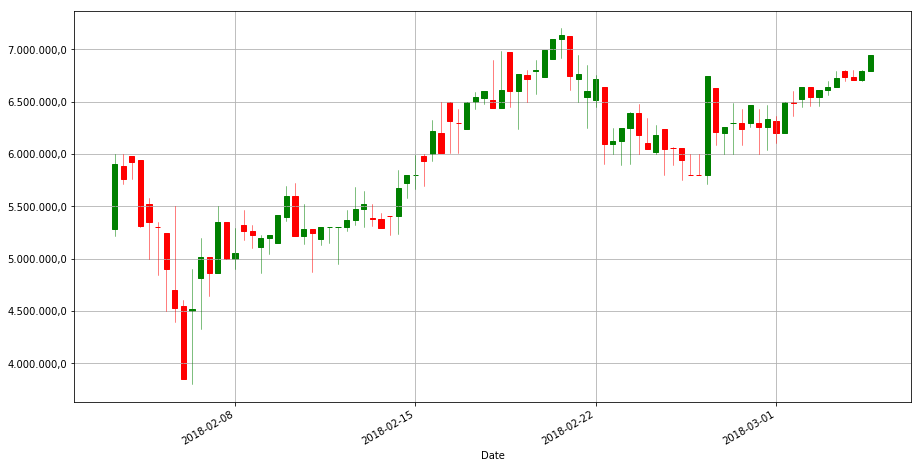

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
from utils import split_thousands

lw_df=lw_df.reset_index()
lw_df['Timestamp'] = lw_df['Timestamp'].map(mdates.date2num)
lw_df.head()

fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.xaxis_date()
plt.xlabel("Date")
ax1.get_yaxis().set_major_formatter(FuncFormatter(split_thousands))

candlestick_ohlc(ax1, lw_df.values, colorup='g', colordown='r')
fig.autofmt_xdate()
plt.grid()
plt.show()

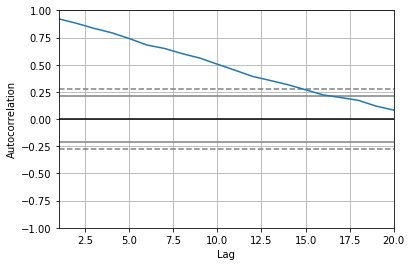

In [4]:
from utils import autocorrelation_plot

df3 = df['Price'].resample('1D').mean().dropna()
#autocorrelation_plot(df3, 20)
open_series = lw_df.open
autocorrelation_plot(open_series, 20);

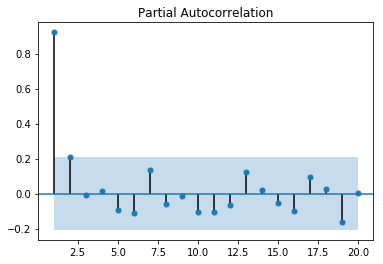

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df4 = df ['Price'].resample('6H').mean().fillna(method='ffill')
df4_series = lw_df.open
plot_pacf(df4_series, lags=20, zero=False);

In [6]:
mean_df = pd.DataFrame(df4)
window_short = 80
window_medium = 200
mean_df['MA20'] = df4.rolling(window=window_short).mean()
mean_df['max'] = df4.rolling(window=window_short).max()
mean_df['min'] = df4.rolling(window=window_short).min()
mean_df['MA50'] = df4.rolling(window=window_medium).mean()
mean_df.tail()

,Price,MA20,max,min,MA50
Timestamp,,,,,
2018-03-03 18:00:00,6774629.4,6247933.5,7155439.2,5180301.1,6541173.7
2018-03-04 00:00:00,6760685.3,6267688.3,7155439.2,5332107.2,6528560.2
2018-03-04 06:00:00,6760513.6,6285355.3,7155439.2,5332107.2,6516470.0
2018-03-04 12:00:00,6730096.2,6302353.4,7155439.2,5332107.2,6503253.4
2018-03-04 18:00:00,6866961.4,6319872.4,7155439.2,5332107.2,6490922.4


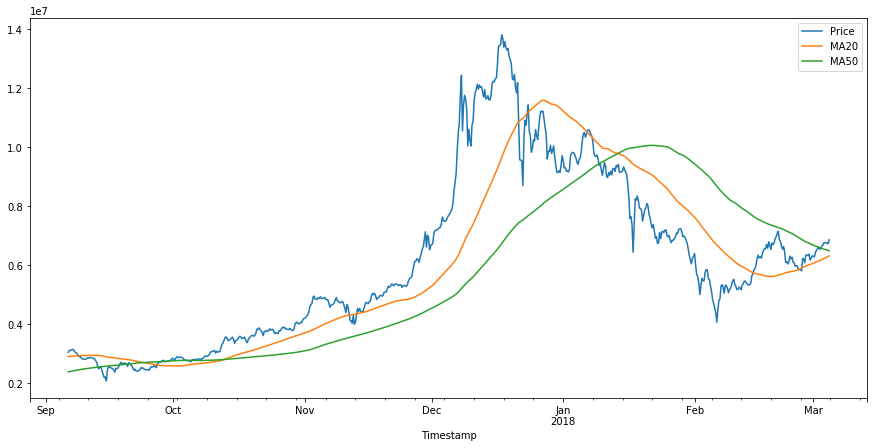

In [7]:
from utils import get_diff_datetime
date_break = get_diff_datetime(60 * 60 * 24 * 30 * 6)
mean_df = mean_df[mean_df.index > date_break]
mean_df[['Price', 'MA20', 'MA50']].plot(figsize=(15,7));

# Predicciones con mean price

en primer lugar vuelvo a cargar el dataset con una función que ya está implementada, por facilidad.

In [8]:
from ann import load_dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset = load_dataset('bitcoin.csv',scaler=scaler, resample='6H', lag=4)

x = dataset.xtrain_mean
y = dataset.ytrain_mean
xt = dataset.xtest_mean
yt = dataset.ytest_mean

x.head()

Using CNTK backend


,Price_t-1,Price_t-2,Price_t-3,Price_t-4
Timestamp,,,,
2015-07-27 00:00:00,-0.0,0.0,-0.0,-0.0
2015-07-27 06:00:00,-0.0,-0.0,0.0,-0.0
2015-07-27 12:00:00,-0.0,-0.0,-0.0,0.0
2015-07-27 18:00:00,-0.0,-0.0,-0.0,-0.0
2015-07-28 00:00:00,0.0,-0.0,-0.0,-0.0


Primera prueba con xgboost con parámetros por defecto, para determinar su rendimiento. Posteriormente se utilizará búsqueda de parámetros.

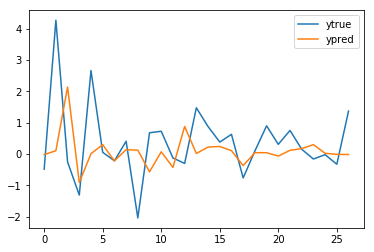

In [9]:
import xgboost as xgb

regressor = xgb.XGBRegressor(n_estimators=200)
regressor.fit(x, y)
ypred = regressor.predict(xt)

plt.plot(yt.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend();

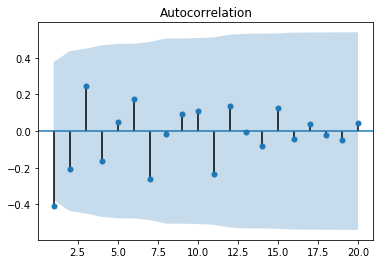

In [10]:
plot_acf(ypred - yt, lags=20, zero=False);
#autocorrelation_plot(ypred - yt, 20)

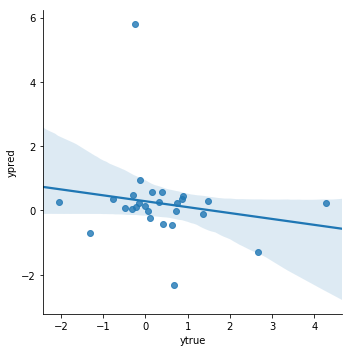

In [28]:
import seaborn as sns

ytrue_plot= pd.Series(yt.values, name='ytrue')
ypred_plot= pd.Series(ypred, name='ypred')
df = pd.DataFrame([ytrue_plot, ypred_plot]).transpose()

sns.lmplot('ytrue', 'ypred', df);

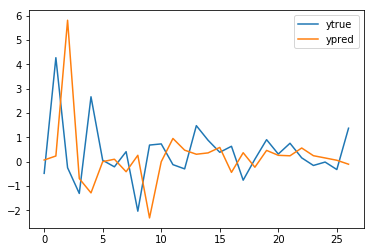

In [11]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(hidden_layer_sizes=(256,), activation='tanh', solver='lbfgs', shuffle=False)
regressor.fit(x, y)
ypred = regressor.predict(xt)

plt.plot(yt.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend();

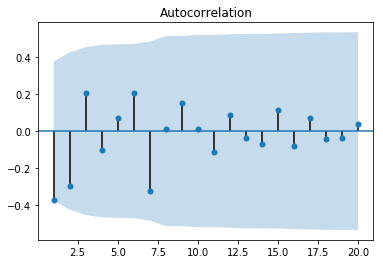

In [12]:
plot_acf(ypred - yt, lags=20, zero=False);